In [1]:
# 让 Notebook 自动重载本地模块改动
%load_ext autoreload
%autoreload 2

import sys
from pathlib import Path

# 添加 TPLC_Net 到 sys.path 以复用 tplc_algo
tplc_net_path = Path(r"D:\degree_code\scheme_1\TPLC_Net")
if str(tplc_net_path) not in sys.path:
    sys.path.append(str(tplc_net_path))

import numpy as np
import pandas as pd
import torch
import matplotlib.pyplot as plt

plt.rcParams['font.sans-serif'] = ['SimHei']
plt.rcParams['axes.unicode_minus'] = False

from tplc_algo.pipeline import prepare_greenhouse_datasets, make_loaders
from tplc_algo.train import Trainer, TrainConfig
from tplc_algo.utils import seed_everything

# 本地 TimeMixer++ 模块
from timemixer_pp_algo.config import TimeMixerPPConfig
from timemixer_pp_algo.model import TimeMixerPPForecaster

# 1. 实验配置与数据准备
这里使用与 baseline (TPLC-Net) 相同的 pipeline 进行数据处理，以确保公平对比。

In [2]:
seed_everything(42)

# ========= 路径配置 =========
# 数据集路径 (根据实际情况修改，保持与 run_TPLC_greenhouse.ipynb 一致)
dataset_root = Path(r'D:\学位会\数据集\温室环境数据(4万条)')
single_file_path = dataset_root / 'GreenhouseClimate1.csv'
team = '.'

# ========= 实验参数 =========
seq_len = 96     # 输入长度
pred_len = 24    # 预测长度
batch_size = 32
epochs = 20
device = 'cuda' if torch.cuda.is_available() else 'cpu'

# ========= 数据准备 =========
print(f"Loading data from {single_file_path}...")
# 使用 tplc_algo 的 pipeline 处理数据
prepared = prepare_greenhouse_datasets(
    dataset_root=dataset_root,
    team=team,
    seq_len=seq_len,
    pred_len=pred_len,
    stride=1,
    base_table='GreenhouseClimate1.csv',
    # 核心特征 (Top 10)
    selected_features=['Tair', 'Rhair', 'CO2air', 'Tot_PAR', 'PipeGrow', 'VentLee', 'Ventwind', 'HumDef', 'water_sup', 'EnScr'],
    missing_rate_threshold=0.7,
    drop_constant=True,
    protect_target_cols=True,
)

feature_cols = prepared.feature_cols
target_cols = prepared.target_cols
print(f"Features ({len(feature_cols)}): {feature_cols}")
print(f"Targets ({len(target_cols)}): {target_cols}")

train_loader, val_loader, test_loader = make_loaders(prepared, batch_size=batch_size)
print(f"Train batches: {len(train_loader)}")

Loading data from D:\学位会\数据集\温室环境数据(4万条)\GreenhouseClimate1.csv...
使用 selected_features: 10 个特征
Features (10): ['CO2air', 'EnScr', 'HumDef', 'PipeGrow', 'Rhair', 'Tair', 'Tot_PAR', 'VentLee', 'Ventwind', 'water_sup']
Targets (3): ['Tair', 'Rhair', 'CO2air']
Train batches: 1042


In [3]:
# ========= 模型配置 =========
import importlib
import timemixer_pp_algo.config
import timemixer_pp_algo.model
import timemixer_pp_algo.layers

# 强制重载以确保 dataclass 字段更新生效
importlib.reload(timemixer_pp_algo.config)
importlib.reload(timemixer_pp_algo.layers)
importlib.reload(timemixer_pp_algo.model)

from timemixer_pp_algo.config import TimeMixerPPConfig
from timemixer_pp_algo.model import TimeMixerPPForecaster

# 计算 target_idx (用于处理 c_out != enc_in 的情况)
try:
    target_idx = [feature_cols.index(col) for col in target_cols]
    print(f"Target indices in feature list: {target_idx}")
except ValueError as e:
    print(f"Error finding targets in features: {e}. Defaulting to None (assuming enc_in=c_out or external denorm).")
    target_idx = None

config = TimeMixerPPConfig(
    seq_len=seq_len,
    pred_len=pred_len,
    enc_in=len(feature_cols),
    c_out=len(target_cols),
    d_model=32,          # 适当增加以提升表达能力
    d_ff=64,
    e_layers=2,
    num_scales=2,        # TimeMixer 核心：多尺度层级
    top_k=3,
    dropout=0.1,
    channel_independence=False,
    target_idx=target_idx # 传入目标索引
)

model = TimeMixerPPForecaster(config)
# print(model) # 可以打印模型结构

# 简单测试一下前向传播
dummy_x = torch.randn(2, seq_len, len(feature_cols)).to(device)
model.to(device)
dummy_out = model(dummy_x)
print(f"Input shape: {dummy_x.shape}")
print(f"Output shape: {dummy_out.shape} (Expected: [Batch, Pred, OutCols])")

Target indices in feature list: [5, 4, 0]
Input shape: torch.Size([2, 96, 10])
Output shape: torch.Size([2, 24, 3]) (Expected: [Batch, Pred, OutCols])


In [4]:
# ========= 训练配置 =========
train_cfg = TrainConfig(
    epochs=epochs,
    lr=1e-3,
    weight_decay=1e-4,
    device=device,
    show_progress=True,
    # 稳定性策略
    lr_scheduler='plateau',
    plateau_patience=3,
    early_stop_patience=5
)

trainer = Trainer(model, train_cfg)

# ========= 开始训练 =========
print(f"Start training TimeMixer++ on {device}...")
history = trainer.fit(train_loader, val_loader=val_loader)

# 最佳验证集结果
min_val_loss = min(history['val_loss'])
print(f"Best Val Loss: {min_val_loss:.4f}")

Start training TimeMixer++ on cuda...


train (epoch):  35%|###5      | 7/20 [22:00<40:51, 188.58s/epoch, train=0.0434, val=0.8052, stop=best@3]

Best Val Loss: 0.7553


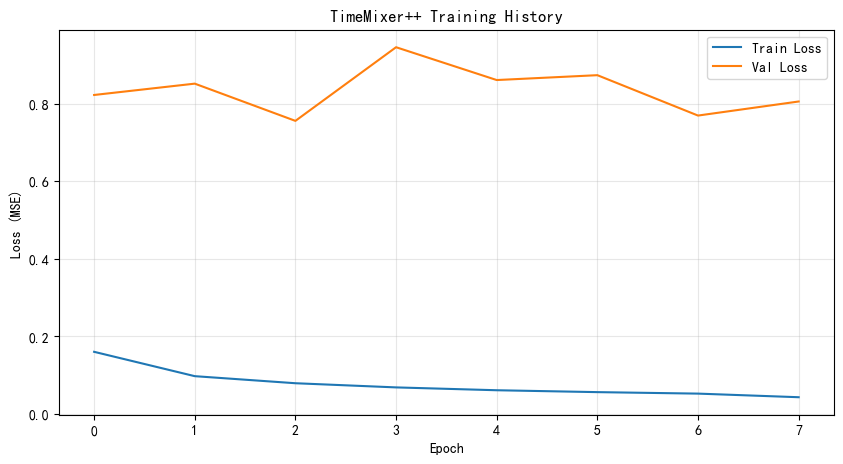

In [5]:
# ========= 结果可视化 =========
plt.figure(figsize=(10, 5))
plt.plot(history['train_loss'], label='Train Loss')
plt.plot(history['val_loss'], label='Val Loss')
plt.title('TimeMixer++ Training History')
plt.xlabel('Epoch')
plt.ylabel('Loss (MSE)')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()